# <center> CLASIFICACIÓN DE IMÁGENES: CELEBRIDADES EN EL DEPORTE </center>

## Taba de contenido
- [0 - Objetivos](#0)
- [1 - Librerías necesarias](#1)
- [2 - Carga y visualización de datos](#2)
- [3 - Pre-procesamiento de datos](#3)
    - [3.1. - División en conjuntos de entrenamiento, validación y test](#3.1)
    - [3.2. - Data Augmentation](#3.2)
- [4 - Modelo](#4)
- [5 - Ajuste de hiperparámetros](#5)
- [6 - Predicciones con el modelo final](#6)
- [7 - Guardando el modelo](#7)
- [6 - Conclusiones](#8)

<a name="0"></a>
## 0. Objetivos

Armar un proyecto de deep learning desde 0.


<a name="1"></a>
## 1. Librerías necesarias

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers,callbacks,models,Sequential,losses
import seaborn as sns
from sklearn.metrics import confusion_matrix
import keras_tuner
from tensorflow import keras
from keras import backend as K
import os


2023-07-10 20:32:57.857241: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-10 20:32:58.449838: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-10 20:32:58.451523: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 20:32:59.938560: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<a name="2"></a>
## 2. Carga y visualización de datos

In [2]:
seed_value = 57
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

Para cargar los datos usaremos "image_dataset_from_directory", que genera un tf.data.Dataset a partir de imágenes en un directorio. <br> <br>
tf.data.Dataset tiene como finalidad trabajar con un conjunto potencialmente grande de elementos.

<br> 
Más info: <a href="https://keras.io/api/data_loading/image/" target='_blanck'> aquí</a>   


In [3]:
data_dir = "archive/Sports-celebrity images"
img_size=256
batch_size=32

df=tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir,
                                                       shuffle=True,
                                                       seed=seed_value,
                                                       image_size=(img_size,img_size),
                                                       batch_size=batch_size)


Found 441 files belonging to 4 classes.


Veamos alguno de los datos

In [4]:
for image_batch,label_batch in df.take(1):
    print('Shape:', image_batch.shape)
    print('Max of the first image:', image_batch.numpy()[1].max())
    print('Min of the first image: ', image_batch.numpy()[1].min())
    print('Labels for the first batch:' , label_batch.numpy())


2023-07-10 20:33:08.241598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [441]
	 [[{{node Placeholder/_0}}]]
2023-07-10 20:33:08.242005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [441]
	 [[{{node Placeholder/_4}}]]


Shape: (32, 256, 256, 3)
Max of the first image: 255.0
Min of the first image:  0.0
Labels for the first batch: [1 1 3 1 0 1 2 2 0 3 3 3 1 3 2 2 2 0 3 3 3 3 1 2 3 2 3 1 2 0 1 2]


Puede verse que:

- El tamaño del lote es 32, y tiene imágenes de 256x256x3 (imágenes a color de 256x256).
- Los valores de la imagen están entre 0 y 255
- Las etiquetas son numéricas (con valores entre 1 y 4)

Definimos entonces

In [5]:
channels=3
input_shape=(img_size,img_size,channels)


Veamos los nombres de las clases y obtengamos su largo:


In [6]:
classes=df.class_names
print(classes)

num_classes = len(classes)

['Kane Williamson', 'Kobe Bryant', 'Maria Sharapova', 'Ronaldo']


Finalmente, imprimamos algunas imágenes:

2023-07-10 20:33:15.527471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [441]
	 [[{{node Placeholder/_4}}]]
2023-07-10 20:33:15.528245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [441]
	 [[{{node Placeholder/_4}}]]


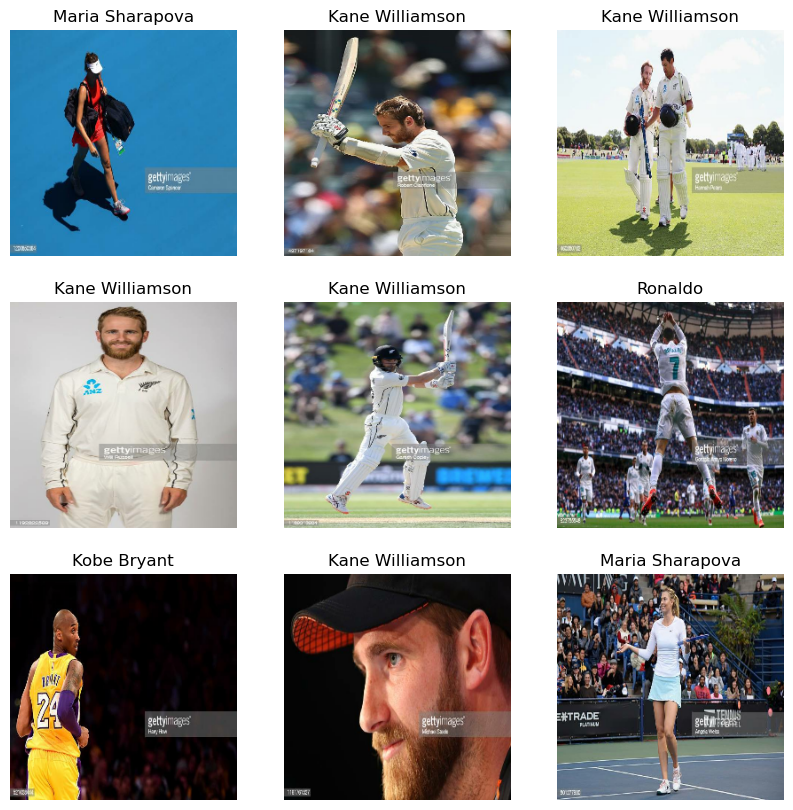

In [7]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in df.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classes[label_batch[i]])
        plt.axis("off")



<a name="3"></a>
## 3. Pre-procesamiento de datos

<a name="3.1"></a>
### 3.1. División en conjuntos de entrenamiento, validación y test

In [8]:
def train_test_split(data,train_split=.7,val_split=.25,
                     test_split=.05,shuffle=True,shuffle_size=10000):
    
    data_size=len(data)
    if shuffle:
        data=data.shuffle(shuffle_size,seed=17)
        
    train_size=int(train_split*data_size)
    val_size=int(val_split*data_size)
    
    train_data=data.take(train_size)
    val_data=data.skip(train_size).take(val_size)
    test_data=data.skip(train_size).skip(val_size)
    
    return train_data,val_data,test_data


train_data,val_data,test_data=train_test_split(df)


<a name="3.2"></a>
### 3.2. Data Augmentation

Como el dataset no es demasiado grande realizaremos un aumento de datos, en el que le aplicaremos transformaciones realistas a las imágenes (como rotaciones, cambio de brillo....). Esto ayuda a exponer al modelo a diferentes aspectos del conjunto de entrenamiento mientras que reduce el overfitting.


In [9]:
# defino las transformaciones
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

# aplico
train_data = train_data.map(
    lambda x, y: (data_augmentation(x, training=True), y))


# para la performance
train_data=train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data=val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data=test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


Veamos cómo luce la aplicación de estas transformaciones:

2023-07-10 20:33:24.008489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [441]
	 [[{{node Placeholder/_4}}]]
2023-07-10 20:33:24.009030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [441]
	 [[{{node Placeholder/_4}}]]


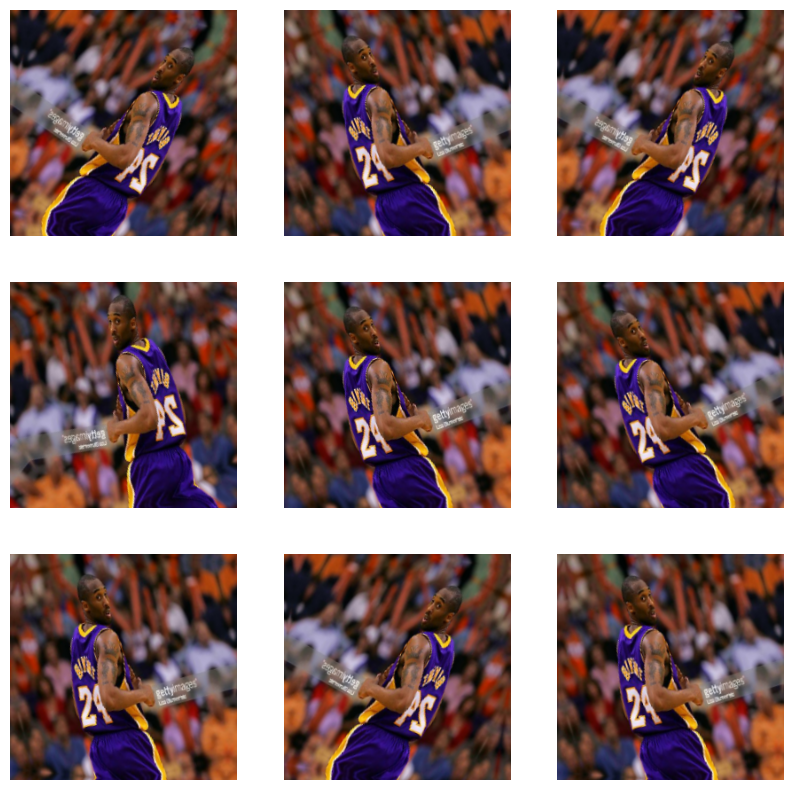

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_data.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


<a name="4"></a>
## 4. Modelo

Comenzaremos implementando el siguiente modelo:


<img src="images/Arquitectura.png"/>


<b>Nota:</b> Si bien es un modelo simple que puede implementarse con la API secuencial, se hará con la funcional para tener más praćtica con ella.



In [11]:
def make_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # escalado
    x = layers.Rescaling(1.0 / 255)(inputs)
    
    
    # capas de conv seguidas de pooling y dropout
    
    for i in range(7):
        x = layers.Conv2D(64, 3, strides=2, padding="same",activation="relu")(x)
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        x = layers.Dropout(0.2)(x)
   
    
    # aplano    
    x = layers.Flatten()(x)
    
    # dense y dropout
    x = layers.Dense(64,activation='relu')(x)
    
    # salida
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    return tf.keras.Model(inputs, outputs)

model = make_model(input_shape=input_shape, num_classes=num_classes)


Veamos la estructura de nuestro modelo:

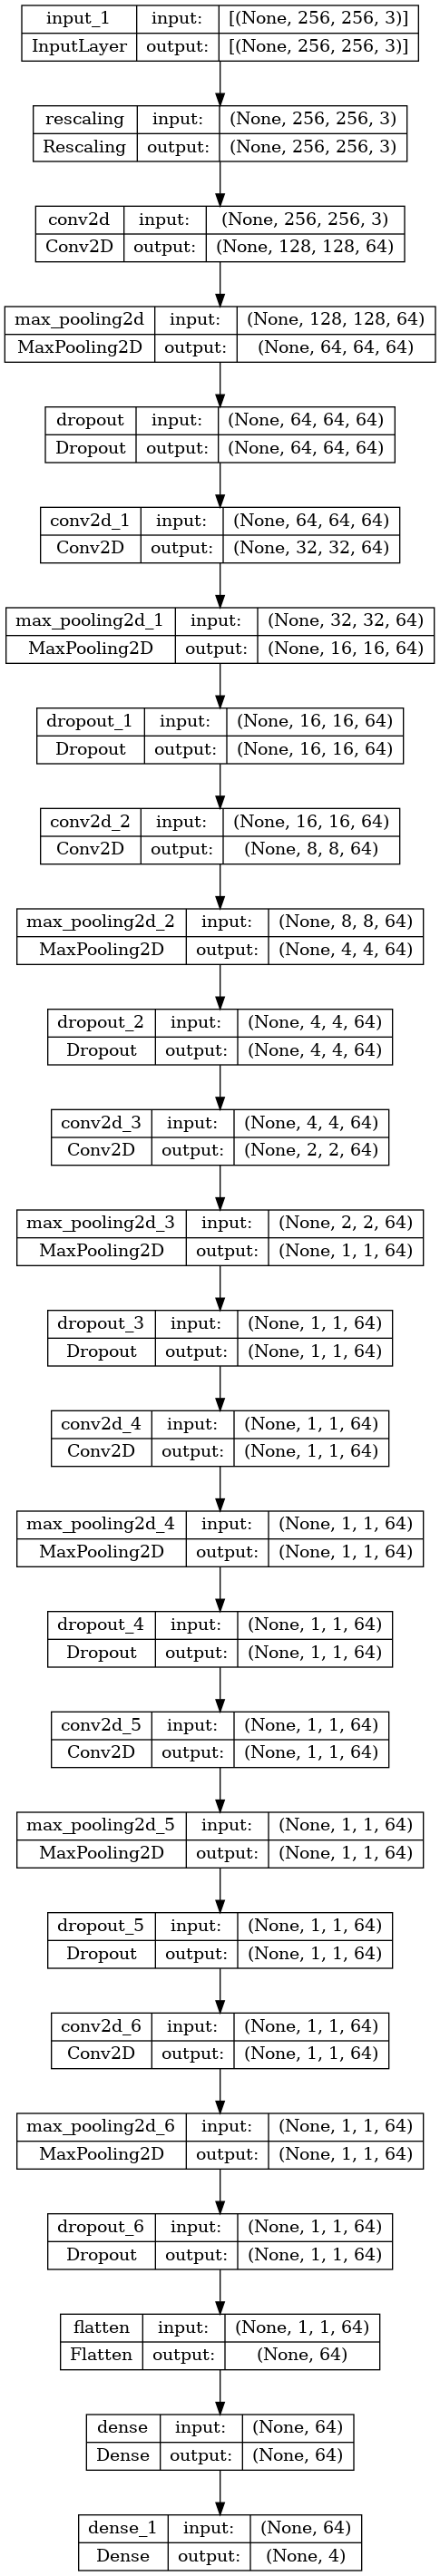

In [12]:
tf.keras.utils.plot_model(model, show_shapes=True)

Compilamos y ajustamos el modelo, como callbacks usaremos EarlyStoppping (para la regularzación) y ModelCheckpoint para ir guardando los resultados intermedios. <br>

In [13]:
# definimos el número de epochs
epochs = 50

In [14]:
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["accuracy"])


callbackss = [
    callbacks.EarlyStopping(monitor='val_loss', patience=20),
    tf.keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras",save_best_only=True),
]

history=model.fit(
                  train_data, 
                  epochs=epochs, 
                  verbose=1,
                  batch_size=batch_size,
                  validation_data=val_data,
                  callbacks=callbackss)

Epoch 1/50


2023-07-10 20:33:46.444386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [441]
	 [[{{node Placeholder/_4}}]]
2023-07-10 20:33:46.444954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [441]
	 [[{{node Placeholder/_4}}]]
2023-07-10 20:33:47.824598: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.
2023-07-10 20:33:48.167283: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.


1/9 [==>...........................] - ETA: 17s - loss: 1.3861 - accuracy: 0.1875

2023-07-10 20:33:48.638375: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.
2023-07-10 20:33:48.896613: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.


2/9 [=====>........................] - ETA: 4s - loss: 1.3851 - accuracy: 0.2344 

2023-07-10 20:33:49.300071: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.


9/9 [==============================] - ETA: 0s - loss: 1.3864 - accuracy: 0.2639

2023-07-10 20:33:52.740944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [441]
	 [[{{node Placeholder/_4}}]]
2023-07-10 20:33:52.741469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [441]
	 [[{{node Placeholder/_4}}]]


9/9 [==============================] - 7s 658ms/step - loss: 1.3864 - accuracy: 0.2639 - val_loss: 1.3819 - val_accuracy: 0.3021
Epoch 2/50
9/9 [==============================] - 5s 575ms/step - loss: 1.3829 - accuracy: 0.2743 - val_loss: 1.3786 - val_accuracy: 0.3021
Epoch 3/50
9/9 [==============================] - 5s 558ms/step - loss: 1.3843 - accuracy: 0.2743 - val_loss: 1.3754 - val_accuracy: 0.3021
Epoch 4/50
9/9 [==============================] - 5s 560ms/step - loss: 1.3795 - accuracy: 0.2743 - val_loss: 1.3742 - val_accuracy: 0.3021
Epoch 5/50
9/9 [==============================] - 5s 572ms/step - loss: 1.3686 - accuracy: 0.2743 - val_loss: 1.3498 - val_accuracy: 0.3021
Epoch 6/50
9/9 [==============================] - 5s 579ms/step - loss: 1.3481 - accuracy: 0.3333 - val_loss: 1.3138 - val_accuracy: 0.3333
Epoch 7/50
9/9 [==============================] - 5s 589ms/step - loss: 1.3485 - accuracy: 0.3819 - val_loss: 1.3131 - val_accuracy: 0.3854
Epoch 8/50
9/9 [===============

In [15]:
scores=model.evaluate(test_data)

2023-07-10 20:37:50.305032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [441]
	 [[{{node Placeholder/_0}}]]
2023-07-10 20:37:50.305657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [441]
	 [[{{node Placeholder/_4}}]]


2/2 [==============================] - 3s 107ms/step - loss: 0.8052 - accuracy: 0.7031


La performance no es muy buena (70%), tendremos que ajustar el modelo.

Grafiquemos para ver la situación con un poco más de detalle:

In [16]:
# helper function
def create_plot(x,y,label):
    plt.plot(range(x),
            y,
            label=label)

Text(0.5, 1.0, 'Training and Validation Loss')

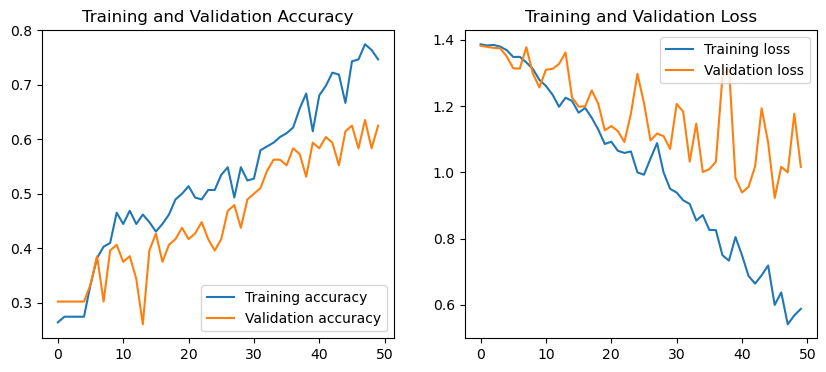

In [17]:
plt.figure(figsize=(10,4))


# Primer gráfico (Accuracy)

plt.subplot(1,2,1)


create_plot(epochs,history.history["accuracy"],label='Training accuracy')
create_plot(epochs,history.history["val_accuracy"],label='Validation accuracy')

plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")


# Segundo gráfico (loss)

plt.subplot(1,2,2)

create_plot(epochs,history.history["loss"],label='Training loss')
create_plot(epochs,history.history["val_loss"],label='Validation loss')

plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

Veamos también la matriz de confusión:

1/1 [==============================] - 0s 99ms/step


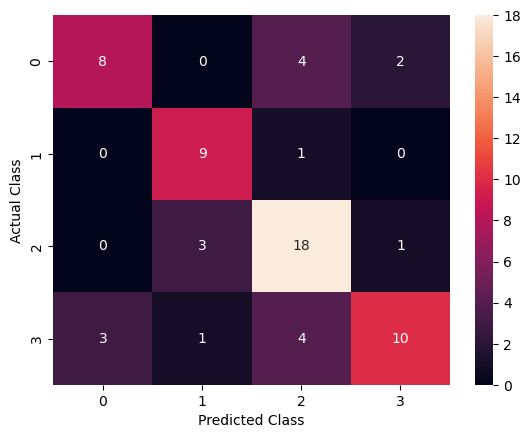

In [18]:
actual_list=[]
pred_list=[]
for X_batch, y_batch in test_data:
    y_batch=y_batch.numpy().tolist()
    y_pred = model.predict(X_batch)
    for i in y_batch:
        actual_list.append(i)
    for j in y_pred:
        pred_list.append(np.argmax(j,axis=-1).tolist())


cm = confusion_matrix(actual_list, pred_list)
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()



<a name="5"></a>
## 5. Ajuste de hiperparámetros

Entre lo que podemos ajustar se encuentran:

- Algoritmo de optimización
- Tasa de aprendizaje
- Número de capas
- Cantidad de unidades en cada capa
- Kernel size
- Pool size
- Dropout rate
- Cantidad de epochs
- Método de inicialización
- Arquitectura de la red



Hay distintos métodos para intentar el ajuste, entre ellos:
    
- GridSearch
- RandomSearch
- Optimización bayesiana

Podemos hacerlo nosotros o utilizar herramientas que ayudan que con esta tarea, como por ejemplo: 
<a href="https://keras.io/keras_tuner/">Keras Tuner </a>.

Aquí utilizaremos Keras tuner y ajustaremos sólo algunos hiperparámetros durante algunos pocos epochs, ya que no tenemos demasiado poder computacional. <br>
Ajustaremos:
- El optimizador
- La tasa de aprendizaje
- El número de veces que repetimos el bloque conv-relu-pool-dropout
- La tasa de dropout

A su vez, usaremos el optimizador bayesiano.


In [19]:
class MyHyperModel(keras_tuner.HyperModel) :
     def build(self, hp, classes=4,input_shape=input_shape):
            
            
        dropout_rate = hp.Choice(name="dropout_rate", values=[0.2, 0.5])
        cant_bloques = hp.Choice(name="cant_bloques", values=[4, 5, 6, 7])

        inputs = tf.keras.Input(shape=input_shape)

        # escalado
        x = layers.Rescaling(1.0 / 255)(inputs)


        # capas de conv seguidas de pooling y dropout

        for i in range(cant_bloques):
            x = layers.Conv2D(64, 3, strides=2, padding="same",activation="relu")(x)
            x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
            x = layers.Dropout(dropout_rate)(x)


        # aplano    
        x = layers.Flatten()(x)

        # dense y dropout
        x = layers.Dense(64,activation='relu')(x)

        # salida
        outputs = layers.Dense(num_classes, activation="softmax")(x)
        
        # modelo
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        
        
        # compilación y demás
        model.compile(optimizer=hp.Choice('optim',['adam','adamax']),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                      metrics = ['accuracy'])
        
        # A way to optimize the learning rate while also trying different optimizers
        learning_rate = hp.Choice('lr', [ 0.03, 0.01, 0.003])
        K.set_value(model.optimizer.learning_rate, learning_rate)
        
        return model
        



In [20]:
tuner = keras_tuner.BayesianOptimization(
                        hypermodel=MyHyperModel(),
                        objective = "val_accuracy",
                        max_trials =10, #max candidates to test
                        overwrite=True,
                        directory='search_dir',
                        project_name='sports_celebrities_dataset')



In [21]:
tuner.search(x=train_data, epochs=5,
             validation_data=val_data)

Trial 10 Complete [00h 00m 22s]
val_accuracy: 0.3020833432674408

Best val_accuracy So Far: 0.4791666567325592
Total elapsed time: 00h 03m 43s
INFO:tensorflow:Oracle triggered exit


In [22]:
tuner.results_summary(1)

Results summary
Results in search_dir/sports_celebrities_dataset
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 07 summary
Hyperparameters:
dropout_rate: 0.2
cant_bloques: 4
optim: adam
lr: 0.003
Score: 0.4791666567325592


In [25]:
dropout_rate = 0.2
cant_bloques = 4
optim = 'adam'
lr = 0.003

Ahora configuraremos nuestro modelo con los parámetros encontrados y lo entrenaremos por 50 epochs:

In [26]:
def make_model(input_shape, num_classes,lr,dropout_rate,cant_bloques):
    
    # entrada
    inputs = tf.keras.Input(shape=input_shape)

    # escalado
    x = layers.Rescaling(1.0 / 255)(inputs)
    
    
    # capas de conv seguidas de pooling y dropout
    
    for i in range(cant_bloques):
        x = layers.Conv2D(64, 3, strides=2, padding="same",activation="relu")(x)
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        x = layers.Dropout(dropout_rate)(x)
   
    
    # aplano    
    x = layers.Flatten()(x)
    
    # dense y dropout
    x = layers.Dense(64,activation='relu')(x)

    # salida
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    
    # modelo
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    # compilamos
    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["accuracy"])
    
    #
    return model
    


In [27]:
model = make_model(input_shape=input_shape, num_classes=num_classes, lr=lr, dropout_rate=dropout_rate, 
                   cant_bloques=cant_bloques)

callbackss = [
    tf.keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras",save_best_only=True),
]

history=model.fit(
                  train_data, 
                  epochs=50, 
                  verbose=1,
                  batch_size=batch_size,
                  validation_data=val_data,
                  callbacks=callbackss)

Epoch 1/50
9/9 [==============================] - 5s 475ms/step - loss: 1.4164 - accuracy: 0.2014 - val_loss: 1.3845 - val_accuracy: 0.1875
Epoch 2/50
9/9 [==============================] - 4s 458ms/step - loss: 1.3790 - accuracy: 0.2917 - val_loss: 1.3687 - val_accuracy: 0.3438
Epoch 3/50
9/9 [==============================] - 4s 454ms/step - loss: 1.3161 - accuracy: 0.3576 - val_loss: 1.2675 - val_accuracy: 0.3854
Epoch 4/50
9/9 [==============================] - 4s 449ms/step - loss: 1.2595 - accuracy: 0.4340 - val_loss: 1.2225 - val_accuracy: 0.4583
Epoch 5/50
9/9 [==============================] - 4s 443ms/step - loss: 1.2879 - accuracy: 0.3681 - val_loss: 1.2737 - val_accuracy: 0.4792
Epoch 6/50
9/9 [==============================] - 4s 478ms/step - loss: 1.2023 - accuracy: 0.4792 - val_loss: 1.2049 - val_accuracy: 0.4479
Epoch 7/50
9/9 [==============================] - 4s 473ms/step - loss: 1.1985 - accuracy: 0.4826 - val_loss: 1.2632 - val_accuracy: 0.3854
Epoch 8/50
9/9 [====

In [28]:
scores=model.evaluate(test_data)

2/2 [==============================] - 0s 144ms/step - loss: 1.1327 - accuracy: 0.8125


Se mejoró bastante, pasamos del 70 al 81%; grafiquemos nuevamente:

Text(0.5, 1.0, 'Training and Validation Loss')

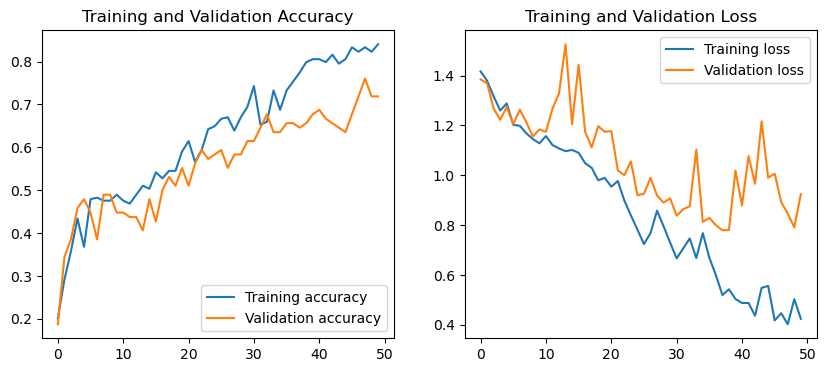

In [29]:
plt.figure(figsize=(10,4))


# Primer gráfico (Accuracy)

plt.subplot(1,2,1)


create_plot(epochs,history.history["accuracy"],label='Training accuracy')
create_plot(epochs,history.history["val_accuracy"],label='Validation accuracy')

plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")


# Segundo gráfico (loss)

plt.subplot(1,2,2)

create_plot(epochs,history.history["loss"],label='Training loss')
create_plot(epochs,history.history["val_loss"],label='Validation loss')

plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

Puede verse que la precisión continúa creciendo con el número de epochs, esto es un indicativo de que podemos entrenar nuestro modelo por una mayor cantidad de epochs.

<a name="6"></a>
## 6. Predicciones con el modelo final

Veamos algunas predicciones con nuestras propias imágenes, previamente escribiremos una función que realice la predicción. Recuerde que nuestro modelo trabaja con imágenes a color de 256x256.

In [30]:
def predicts(model,img):
    
    img = np.resize(img,(256,256)) # ver bien
    
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    
    predictions=model.predict(img_array)

    
    predicted_class=classes[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    
    return predicted_class,confidence

Veamos algunas predicciones sobre nuestro conjunto de test:

1/1 [==============================] - 0s 74ms/step


2023-07-10 20:51:48.239096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [441]
	 [[{{node Placeholder/_0}}]]
2023-07-10 20:51:48.239641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [441]
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 23ms/step


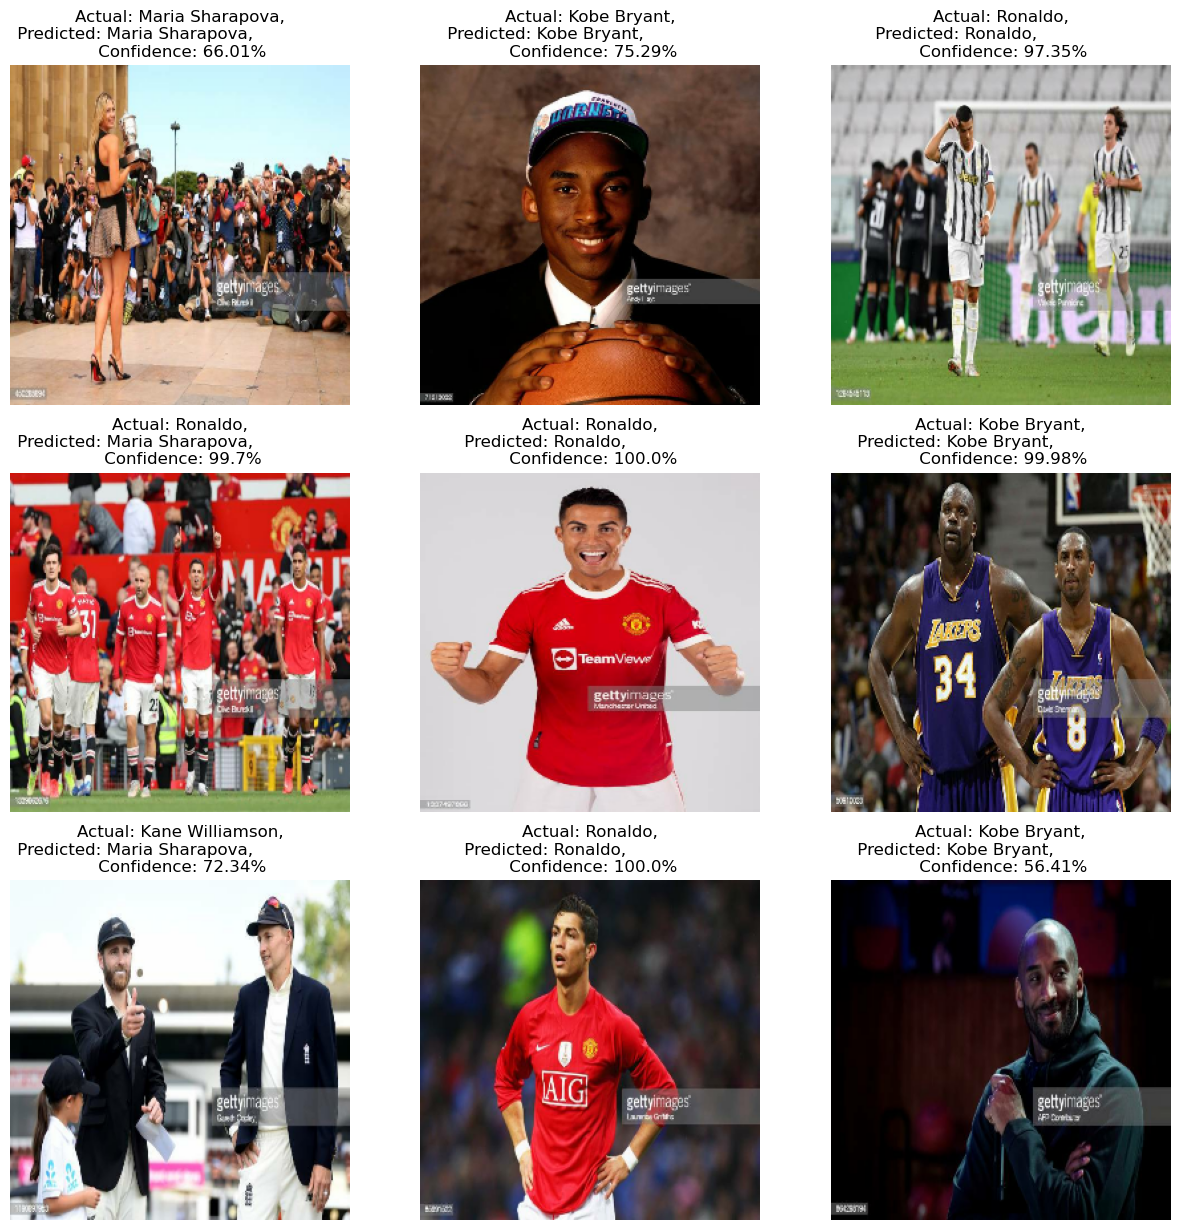

In [31]:
plt.figure(figsize=(15,15))
for images,labels in test_data.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predicts(model,images[i].numpy())
        actual_class=classes[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\
                  \n Confidence: {confidence}%")
        plt.axis("off")


Ahora realizaremos una predicción sobre una imagen nuestra:

In [32]:
image_size = (256, 256)

img = keras.utils.load_img(
    "my_test_images/maria.png", target_size=image_size
)
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)

indice_max = np.argmax(predictions[0])

prob_class = predictions[0][indice_max]
predicted_class=classes[indice_max]


print(f"Se predice {predicted_class} con una confianza de {100*prob_class:.2f}%")



1/1 [==============================] - 0s 18ms/step
Se predice Maria Sharapova con una confianza de 61.95%


<a name="7"></a>
## 7. Guardando el modelo

Ahora guardaremos el modelo, que consiste de múltiples componentes:
    
- Su arquitectura 
- Los pesos
- El optimizador
- El conjunto de métricas y pérdidas

In [74]:
model.save('model.keras') 

Para cargarlo simplemente escribimos:

In [75]:
model = keras.models.load_model('model.keras')

In [77]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 64, 64, 64)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 64)        36928     
                                                           

<a name="8"></a>
## Conclusiones

Se entreno un modelo para la clasificación de imágenes de celebridades del deporte.